In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data = pd.read_csv('data.csv', sep=';', encoding='utf-8')

In [3]:
data = data.fillna(0)

In [4]:
data = data.drop("Unnamed: 0", axis=1)

In [5]:
cards = pd.read_csv("cards.csv", sep=";", encoding='utf-8')

In [6]:
cards = cards.drop("Unnamed: 0", axis=1)

In [7]:
data = data.drop("useless_stuff", axis=1)

In [8]:
data["receipt"] = data["receipt"].apply(lambda s: int(s.replace('\xa0','')))

In [9]:
item_ids = data.item_id

In [10]:
item_names = data.item_name

In [11]:
item_to_myid = {name: i for i, name in enumerate(item_names.unique())}

In [12]:
data["item_id"] = data.item_name.apply(lambda v:item_to_myid[v])

In [13]:
X_train, X_valid ,X_test = data[:len(data)-2*round(len(data)/5)], data[len(data)-2*round(len(data)/5):len(data)-round(len(data)/5)], data[len(data)-round(len(data)/5):]

In [14]:
groupby_train = X_train.groupby("receipt")

In [15]:
from scipy.sparse import dok_matrix
from scipy.sparse.linalg import svds


In [16]:
F = dok_matrix((max(X_train.receipt)+1,max(X_train.item_id)+1))

In [17]:
groupby_train.get_group(list(groupby_train.groups.keys())[5])

,position,receipt,date,time,item_id,item_name,price,quantity,total,discount
6,1,80,19.02.2014,15:34:51,6,ШАМПУНЬ Head & Shoulders против выпадения воло...,238.0,1,226.0,11.90
7,2,80,19.02.2014,15:34:51,7,"ГЕЛЬ Gillette Series для бритья, для сухой кож...",202.0,1,192.0,10.10
8,3,80,19.02.2014,15:34:51,8,"ПОМАЗОК Schick для бритья, блистер, 1 шт, ГЕРМ...",346.0,1,328.5,17.30
9,4,80,19.02.2014,15:34:51,9,"АРОМАТИЗАТОР Deliss Comfort для автомобиля, бл...",309.0,1,293.5,15.45
10,5,80,19.02.2014,15:34:51,10,ОПОЛАСКИВАТЕЛЬ Colgate Plax Ice для полости рт...,100.0,1,95.0,5.00
11,6,80,19.02.2014,15:34:51,11,"ДЕЗОДОРАНТ - АНТИПЕРСПИРАНТ Mennen SS мужской,...",148.0,1,140.5,7.40


In [18]:
for group_name in groupby_train.groups.keys():
    for item in groupby_train.get_group(group_name).item_id:
        F[group_name, item] = 1
F = F.tocsr()
F = F[np.where(np.array(F.sum(axis=1))[:,0]!=0)[0],:]

In [19]:
k = 10

In [20]:
A, h, B = svds(F, k=k)

In [21]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

#cluster_ids = DBSCAN(eps=0.01, min_samples=4).fit_predict(B.T)

In [22]:
items = {key: value for key, value in zip(X_train.item_id, X_train.item_name)}

for i in range(1,len(set(cluster_ids))-1):
    print([items[i] for i in np.nonzero(cluster_ids==i)[0]])
    print()

NameError: name 'cluster_ids' is not defined

In [23]:
from collections import Counter

In [24]:
Counter(cluster_ids)

NameError: name 'cluster_ids' is not defined

In [25]:
group_ind = dict(enumerate(list(groupby_train.groups.keys())))

In [26]:
def assign_clusters(X, receipt, cluster_ids):
    try:
        ite = X[X.receipt == receipt].item_id.values
        clusters = list(map(lambda x: cluster_ids[x], ite))
    except IndexError:
        clusters = [-1]
    return clusters

In [27]:
def similarity(a, b):
    len_a = sum(a**2)**0.5
    len_b = sum(b**2)**0.5
    ab_inner = np.inner(a, b)
    return ab_inner/(len_a*len_b)

In [28]:
def acc(rvc, rvi):
    sm = []
    for i in range(len(rvc)):
        sm.append(similarity(rvc[i], rvi[i]))
    return min(sm), np.mean(sm), max(sm)

In [29]:
clusters_vectors = []

In [30]:
for cluster in set(cluster_ids):
    clusters_vectors.append(B.T[np.where(cluster_ids == cluster)])

NameError: name 'cluster_ids' is not defined

In [31]:
vects = np.array(list(map(lambda x: np.mean(x, axis=0), clusters_vectors)))

In [112]:
receipts_clusters = []

In [113]:
for receipt in set(X_test.receipt.values):
    receipts_clusters.append(assign_clusters(X_test, receipt))
    if assign_clusters(X_test, receipt)[0] > 82:
        print(receipt)

In [114]:
receipts_clusters = list(map(lambda x: list(set(x)), receipts_clusters))

In [116]:
receipts_vectors_c = []

In [117]:
for r in receipts_clusters:
    receipts_vectors_c.append(np.mean([cv for cv in vects[r]], axis=0))

In [118]:
receipts_vectors_c = np.array(receipts_vectors_c)

In [120]:
receipts_vectors_i = []

In [122]:
for r in set(X_test.receipt.values):
    ite = X_test[X_test.receipt == receipt].item_id.values
    ivects = B.T[ite]
    receipts_vectors_i.append(np.mean(ivects, axis=0))

In [123]:
receipts_vectors_i = np.array(receipts_vectors_i)

In [19]:
groupby_valid = X_valid.groupby("receipt")

In [22]:
F_valid = dok_matrix((max(X_valid.receipt)+1,max(X_valid.item_id)+1))
for group_name in groupby_valid.groups.keys():
    for item in groupby_valid.get_group(group_name).item_id:
        F_valid[group_name, item] = 1
F_valid = F_valid.tocsr()
F_valid = F_valid[np.where(np.array(F_valid.sum(axis=1))[:,0]!=0)[0],:]

In [23]:
from tqdm import tqdm

In [76]:
F_test = dok_matrix((max(X_test.receipt)+1,max(X_test.item_id)+1))
for group_name in groupby_valid.groups.keys():
    for item in groupby_valid.get_group(group_name).item_id:
        F_test[group_name, item] = 1
F_test = F_test.tocsr()
F_test = F_test[np.where(np.array(F_test.sum(axis=1))[:,0]!=0)[0],:]

In [21]:
def get_params():
    for k in range(10, 200, 20):
        for eps in np.linspace(1e-4, 1e-2, 10):
            for smplsnum in range(3, 6):
                yield k, eps, smplsnum

In [22]:
def validate(params, mode='validate'):
    
    X = X_valid
    F = F_valid
    
    if mode == "test":
        X = X_test
        F = F_test
    
    k = params[0]
    eps = params[1]
    smplsnum = params[2]
    
    accs = []
    print("Using:", "k=", k, "eps=", eps, "min_samples=", smplsnum)

    A, h, B = svds(F, k=k)
    print("Finished SVD")

    cluster_ids = DBSCAN(eps=eps, min_samples=smplsnum).fit_predict(B.T)
    
    print("Finished DBSCAN")

    clusters_vectors = []
    for cluster in set(cluster_ids):
        clusters_vectors.append(B.T[np.where(cluster_ids == cluster)])
    vects = np.array(list(map(lambda x: np.mean(x, axis=0), clusters_vectors)))
    
    print("Finished vectorizing clusters")

    receipts_clusters = []
    for receipt in set(X.receipt.values):
        receipts_clusters.append(assign_clusters(X, receipt, cluster_ids))
    receipts_clusters = list(map(lambda x: list(set(x)), receipts_clusters))
    
    print("Finished clustering receipts")

    receipts_vectors_c = []
    for r in receipts_clusters:
        receipts_vectors_c.append(np.mean([cv for cv in vects[r]], axis=0))
    receipts_vectors_c = np.array(receipts_vectors_c)
    
    print("Finished vectorizing receipts by clusters")

    receipts_vectors_i = []
    for r in set(X.receipt.values):
        ite = X[X.receipt == r].item_id.values
        ivects = B.T[ite]
        receipts_vectors_i.append(np.mean(ivects, axis=0))
    receipts_vectors_i = np.array(receipts_vectors_i)
    
    print("Finished vectorizing receipts by items")

    accs.append([(k, eps, smplsnum), acc(receipts_vectors_c, receipts_vectors_i)])
    print("Accuracy:", acc(receipts_vectors_c, receipts_vectors_i))
    
    return accs

In [80]:
Counter(DBSCAN(eps=0.1, min_samples=4).fit_predict(svds(F_test, k=10)[2].T))

Counter({-1: 21, 0: 10956})

In [35]:
from concurrent import futures
from copy import deepcopy

In [25]:
with futures.ThreadPoolExecutor(150) as executor:
    full_accs = executor.map(validate, get_params())

Using: k= 10 eps= 0.0001 min_samples= 3
Using: k= 10 eps= 0.0001 min_samples= 4
Using: k= 10 eps= 0.0001 min_samples= 5
Using: k= 10 eps= 0.0012 min_samples= 3
Using: k= 10 eps= 0.0012 min_samples= 4
Using: k= 10 eps= 0.0012 min_samples= 5
Using: k= 10 eps= 0.0023 min_samples= 3
Using: k= 10 eps= 0.0023 min_samples= 4
Using: k= 10 eps= 0.0023 min_samples= 5
Using: k= 10 eps= 0.0034 min_samples= 3
Using: k= 10 eps= 0.0034 min_samples= 4
Using: k= 10 eps= 0.0034 min_samples= 5
Using: k= 10 eps= 0.0045 min_samples= 3
Using: k= 10 eps= 0.0045 min_samples= 4
Using: k= 10 eps= 0.0045 min_samples= 5
Using: k= 10 eps= 0.0056 min_samples= 3
Using: k= 10 eps= 0.0056 min_samples= 4
Using: k= 10 eps= 0.0056 min_samples= 5
Using: k= 10 eps= 0.0067 min_samples= 3
Using: k= 10 eps= 0.0067 min_samples= 4
Using: k= 10 eps= 0.0067 min_samples= 5
Using: k= 10 eps= 0.0078 min_samples= 3
Using: k= 10 eps= 0.0078 min_samples= 4
Using: k= 10 eps= 0.0078 min_samples= 5
Using: k= 10 eps= 0.0089 min_samples= 3


In [27]:
laccs = list(full_accs)

In [27]:
import pickle as pkl

In [32]:
with open("laccs.pkl", "wb") as f:
    pkl.dump(laccs, f)

In [41]:
laccs = deepcopy(laccs_test)

In [32]:
laccs = np.array(laccs)

In [30]:
with open("laccs.pkl", "rb") as f:
    laccs = pkl.load(f)

In [33]:
laccs.shape

(300, 1, 2, 3)

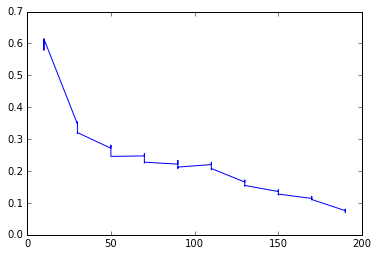

In [42]:
plt.plot(laccs[:, :, 0, 0], laccs[:, :, 1, 1])

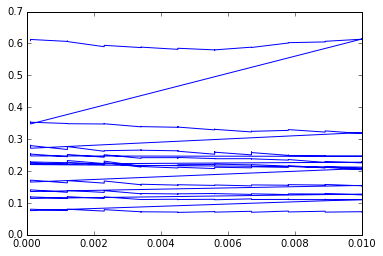

In [43]:
plt.plot(laccs[:, :, 0, 1], laccs[:, :, 1, 1])

In [36]:
%matplotlib inline

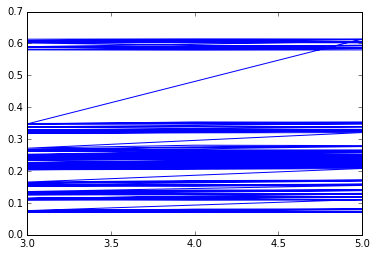

In [44]:
plt.plot(laccs[:, :, 0, 2], laccs[:, :, 1, 1])

In [161]:
validate((10, 0.01, 4))

Using: k= 10 eps= 0.01 min_samples= 4
Finished SVD
Finished DBSCAN
Finished vectorizing clusters
Finished clustering receipts
Finished vectorizing receipts by clusters
Finished vectorizing receipts by items
Accuracy: (-0.46778719849657507, 0.60836568454297413, 0.99960367404192041)


[[(10, 0.01, 4),
  (-0.46778719849657507, 0.60836568454297413, 0.99960367404192041)]]

In [51]:
for eps in np.linspace(1e-5, 1e-2, 30):
    validate((10, eps, 4))

Using: k= 10 eps= 1e-05 min_samples= 4
Finished SVD
Finished DBSCAN
Finished vectorizing clusters
Finished clustering receipts
Finished vectorizing receipts by clusters
Finished vectorizing receipts by items
Accuracy: (0.014561510937712019, 0.61122453322154058, 0.82636704534425054)
Using: k= 10 eps= 0.000354482758621 min_samples= 4
Finished SVD
Finished DBSCAN
Finished vectorizing clusters
Finished clustering receipts
Finished vectorizing receipts by clusters
Finished vectorizing receipts by items
Accuracy: (-0.096625001058457338, 0.6068231482925337, 0.92631004192479394)
Using: k= 10 eps= 0.000698965517241 min_samples= 4
Finished SVD
Finished DBSCAN
Finished vectorizing clusters
Finished clustering receipts
Finished vectorizing receipts by clusters
Finished vectorizing receipts by items
Accuracy: (-0.1130817722097274, 0.60459034207623363, 0.9473870944604722)
Using: k= 10 eps= 0.00104344827586 min_samples= 4
Finished SVD
Finished DBSCAN
Finished vectorizing clusters
Finished clustering 

In [162]:
validate((20, 0.00089965517241, 4), mode='test')

Using: k= 20 eps= 0.00089965517241 min_samples= 4
Finished SVD
Finished DBSCAN
Finished vectorizing clusters
Finished clustering receipts
Finished vectorizing receipts by clusters
Finished vectorizing receipts by items
Accuracy: (-0.41643581790110357, nan, 1.0000000000000002)


[[(20, 0.00089965517241, 4), (-0.41643581790110357, nan, 1.0000000000000002)]]

In [96]:
Counter(DBSCAN(eps=0.00089965517241, min_samples=4).fit_predict(svds(F_test, k=20)[2].T))

Counter({-1: 3626,
         0: 6948,
         1: 6,
         2: 5,
         3: 6,
         4: 7,
         5: 4,
         6: 9,
         7: 5,
         8: 7,
         9: 7,
         10: 8,
         11: 4,
         12: 5,
         13: 4,
         14: 15,
         15: 7,
         16: 6,
         17: 5,
         18: 4,
         19: 7,
         20: 8,
         21: 6,
         22: 6,
         23: 5,
         24: 6,
         25: 5,
         26: 7,
         27: 5,
         28: 5,
         29: 8,
         30: 7,
         31: 7,
         32: 11,
         33: 5,
         34: 18,
         35: 4,
         36: 4,
         37: 4,
         38: 5,
         39: 5,
         40: 4,
         41: 4,
         42: 4,
         43: 4,
         44: 5,
         45: 8,
         46: 4,
         47: 5,
         48: 5,
         49: 4,
         50: 4,
         51: 6,
         52: 4,
         53: 4,
         54: 5,
         55: 4,
         56: 6,
         57: 4,
         58: 5,
         59: 4,
         60: 4,
         

In [25]:
cluster_ids = DBSCAN(eps=0.00089965517241, min_samples=4).fit_predict(svds(F, k=20)[2].T)

In [134]:
np.where(cluster_ids==34)

(array([1819, 2431, 2667, 2955, 3108, 3913, 4223, 4648, 5325, 5794, 5944,
        6159, 7686, 7761, 7838, 8453, 8454, 9343]),)

In [32]:
F = dok_matrix((max(data.receipt)+1,max(data.item_id)+1))
groupby = data.groupby("receipt")
for group_name in groupby.groups.keys():
        for item in groupby.get_group(group_name).item_id:
            F[group_name, item] = 1
F = F.tocsr()
F = F[np.where(np.array(F.sum(axis=1))[:,0]!=0)[0],:]
_, _, B = svds(F, k=20)
cluster_ids = DBSCAN(eps=0.00089965517241, min_samples=4).fit_predict(B.T)

In [33]:
receipts_vectors_i = []
for r in set(data.receipt.values):
    ite = data[data.receipt == r].item_id.values
    ivects = B.T[ite]
    receipts_vectors_i.append(np.mean(ivects, axis=0))
receipts_vectors_i = np.array(receipts_vectors_i)

In [34]:
def recommend(receipt, cluster_ids):
    receipt_vec = receipts_vectors_i[list(set(data.receipt.values)).index(receipt)]
    receipt_clusters = list(set(assign_clusters(data, receipt, cluster_ids)))
    recommendation = []
    for cluster in receipt_clusters:
        recommendation.extend(list(np.where(cluster_ids == cluster)[0]))
    true_recommendation = []
    for item in recommendation:
        if item not in data[data.receipt == receipt].item_id.values:
            true_recommendation.append(item)
    ri_similarity = list(map(lambda x: similarity(x, receipt_vec), B.T[true_recommendation]))
    its = sorted(list(zip(ri_similarity, true_recommendation)), reverse=True)
    return list(map(items.get, list(map(lambda x: x[1], its[:5]))))

In [44]:
data[data.receipt == 43324]

,position,receipt,date,time,item_id,item_name,price,quantity,total,discount
111806,1,43324,12.04.2016,17:46:12,8495,"ВЕДРО Ромашка 10 л, с апликацией, без упаковки...",289.0,1,260.0,28.90
111807,2,43324,12.04.2016,17:46:12,1666,"КОЛГОТКИ Innamore Bella 40 Miele 3, п/э упаков...",177.0,1,159.5,17.70
111808,3,43324,12.04.2016,17:46:12,1430,"МЕШКИ Bami Unicum для мусора, синие, 180 л, ру...",214.0,1,192.5,21.40
111809,4,43324,12.04.2016,17:46:12,5541,ГЛИНА Фито Косметик Камчатская вулканическая п...,46.5,1,42.0,4.65


In [45]:
recommend(9732, cluster_ids)

[None,
 'СКАТЕРТЬ Tablecloth Vinyl ажурная, белая, 110*140 см, п/э упаковка, 1 шт, ТАЙВАН',
 "ТОНИК L'Oreal для сухой кожи лица, флакон, 200 мл, ГЕРМАНИЯ",
 'ЛАМПА НАКАЛИВАНИЯ Philips 40 Вт/390 Лм, шарик, матовая, цоколь Е27, коробка, 1 ш',
 None]

In [158]:
Counter(cluster_ids)

Counter({-1: 4238,
         0: 4993,
         1: 92,
         2: 56,
         3: 106,
         4: 66,
         5: 38,
         6: 204,
         7: 195,
         8: 32,
         9: 102,
         10: 67,
         11: 28,
         12: 43,
         13: 18,
         14: 76,
         15: 27,
         16: 31,
         17: 7,
         18: 68,
         19: 6,
         20: 4,
         21: 58,
         22: 37,
         23: 53,
         24: 58,
         25: 36,
         26: 7,
         27: 7,
         28: 12,
         29: 21,
         30: 14,
         31: 5,
         32: 6,
         33: 5,
         34: 4,
         35: 9,
         36: 11,
         37: 7,
         38: 5,
         39: 7,
         40: 4,
         41: 4,
         42: 33,
         43: 5,
         44: 6,
         45: 5,
         46: 4,
         47: 5,
         48: 4,
         49: 4,
         50: 4,
         51: 4,
         52: 5,
         53: 6,
         54: 4,
         55: 5,
         56: 4,
         57: 4,
         58: 4,
         59: 